##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>


In [ ]:
#@title
%%html
<iframe src="https://www.polskacyfrowa.gov.pl/media/48246/FE_POPC_poziom_pl-1_rgb.jpg" width="800"></iframe>


# Uczenie głębokie

Jacek Rumiński, Politechnika Gdańska, Wydział ETI, Katedra Inżynierii Biomedycznej

**Wykład 5:** Architektury sieci splotowych

**Przykład (1):** Wartości początkowe parametrów


W ramach tego notatnika przedstawiamy przykładowe kody umożliwiające praktyczne zapoznanie się z wykorzystaniem różnych metod ustawiania wartości początkowych parametrów podlegających procesowi uczenia.

Wskażmy pakiety, z jakich będziemy korzystać:


In [ ]:
import numpy as np
import datetime, os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set_theme()
from matplotlib.colors import ListedColormap
import tensorflow as tf
from tensorflow.keras.regularizers import L2
from tensorflow.keras.datasets import cifar10

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

# You can try to change your Google Colab environment to GPU
print(tf.__version__)

# You can always check which packages are installed using:
# !pip list

2.6.0


In [ ]:
# Check if you have GPU resources (Runtime / Change runtime type -> GPU)
!nvidia-smi

Thu Nov  4 15:52:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    61W / 149W |   2305MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Check devices using TF
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Zróbmy eksperyment ponownie z danymi CIFAR-10.

True original label : 6 frog


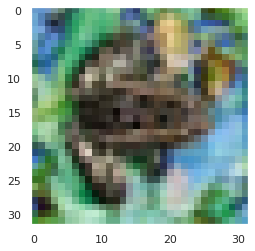

In [ ]:
# Load data and split to training and test datasets

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = [
'airplane','automobile','bird', 'cat', 'deer' ,
'dog', 'frog', 'horse', 'ship', 'truck']

# Data properties
image_width = 32;
image_height = 32;
image_components = 3

# Show an example
example = 200
class_id = y_train[example].item()

plt.rcParams["axes.grid"] = False
plt.imshow(x_train[example])
print("True original label :", class_id, class_names[class_id])


Przygotujmy dane dobierając metodę normalizacji/standaryzacji danych wejściowych.

In [ ]:
# Show the shape of input data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("X train dataset shape: ", x_train.shape)
print("Max value in X train: ", np.max(x_train))

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Normalize image data

# You can try to standsardize images (using mean and std. dev.)
standardize = True

if standardize:
    # per channel:
    for i in range(3):
        x_train_mean = np.mean(x_train[:,:,:,i])
        x_train_std = np.std(x_train[:,:,:,i])
        x_train[:,:,:,i] = (x_train[:,:,:,i] -x_train_mean) / x_train_std
        x_test[:,:,:,i] = (x_test[:,:,:,i] -x_train_mean) /x_train_std

    # per dataset:
#     x_train_mean = np.mean(x_train)
#     x_train_std = np.std(x_train)

#     x_train = (x_train - x_train_mean)/x_train_std
#     x_test = (x_test - x_train_mean)/x_train_std

else:
    x_train = x_train / 255.0
    x_test = x_test / 255.0


# Set some parameters
no_of_classes = 10

X train dataset shape:  (50000, 32, 32, 3)
Max value in X train:  255.0


Zaproponujmy dwie przykładowe architektury modeli splotowych, zgodnie z poznanymi wcześniej operacjami, implementowwanymi jako warstwy modelu głęboiego.

W modelu 1 wykorzystujemy zestawy bloków typu Conv+BN+ReLU oraz regularyzację wag (L2 - rozpad wag).

W modelu 2 wykorzystujemy przestawienie kolejności operacji, tj. stosujemy bloki Conv+ReLU+BN oraz nie stosujemy regularyzacji wag na poziomie definicji warstw modelu sieci głębokiej.


In [ ]:
# Define the Model

# weight_decay parameter
wd = 0.0005

act = 'relu'
# act = 'elu'

pad = 'same'
# pad = 'valid'

# Make your test with different configurations and compare
# the training process (metrics change in epochs)
# e.g. start from 'zeros' for kernel and bias, then he_uniform vs. he_normal,
# random_normal vs. glorot_normal, etc.

# w_init = 'random_uniform'
# w_init = 'random_normal'
# w_init = 'glorot_uniform'
# w_init = 'glorot_normal'
w_init = 'he_uniform'
# w_init = 'he_normal'
# w_init = 'zeros'
b_init = 'zeros'
# b_init = 'ones'

def get_CNN_model_3():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, input_shape=x_train.shape[1:], activation=None, padding=pad,
                               kernel_regularizer=L2(wd), bias_regularizer=L2(wd),
                               kernel_initializer=w_init, bias_initializer=b_init),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2D(32, 3, padding=pad, activation=None,
                               kernel_regularizer=L2(wd), bias_regularizer=L2(wd),
                               kernel_initializer=w_init, bias_initializer=b_init),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, 3, padding=pad, activation=None,
                               kernel_regularizer=L2(wd), bias_regularizer=L2(wd),
                               kernel_initializer=w_init, bias_initializer=b_init),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2D(64, 3, padding=pad, activation=None,
                               kernel_regularizer=L2(wd), bias_regularizer=L2(wd),
                               kernel_initializer=w_init, bias_initializer=b_init),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(128, 3, padding=pad, activation=None,
                               kernel_regularizer=L2(wd), bias_regularizer=L2(wd),
                               kernel_initializer=w_init, bias_initializer=b_init),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2D(128, 3, padding=pad, activation=act,
                               kernel_regularizer=L2(wd), bias_regularizer=L2(wd),
                               kernel_initializer=w_init, bias_initializer=b_init),
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(128, activation=act,
                              kernel_regularizer=L2(wd), bias_regularizer=L2(wd),
                              kernel_initializer=w_init, bias_initializer=b_init),
        tf.keras.layers.Dense(no_of_classes, activation='softmax',
                              kernel_regularizer=L2(wd), bias_regularizer=L2(wd),
                              kernel_initializer=w_init, bias_initializer=b_init)
    ])

    return model




Przygotujmy ustawienia procedury uczenia.

In [ ]:
def train_model(model, callbacks, opt, epochs=10, batch_size=32):
  """
  Train model - use some global variable (you can modify the definition
                to make this function more univeral)

  """

  model.compile(
    # Choose the optimizer
    optimizer=opt,
    loss='categorical_crossentropy',
    # Introduce additional metric
    metrics=['accuracy']
  )

  model.fit(x=x_train,
            y=y_train,
            epochs=epochs,
            batch_size=batch_size,
            # Use test data to perform validation
            validation_data=(x_test, y_test),
            # Assign reference to the TB callback function
            callbacks=callbacks)

Zdefiniujmy stosowne hiperparametry, wypbierzmy model oraz algorytm optymalizacji, a następnie przeprowadźmy trening. Z góry zachęcam do przeprowadzenia wielu eksperymentów z różnymi ustawieniami modelu oraz algorytmu optymalizacyjnego.


In [ ]:
# Use "logs" folder to for TB data
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# All callback functions
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks = [tensorboard_callback]

# Select the model
model_to_train = get_CNN_model_3()

model_to_train.summary()

# Redefine hiperparameters - e.g. use more epoch in the experiments
# epochs = 200
epochs = 20
batch_size = 128
learning_rate = 0.01

# You can try different optimalization algorithms
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate*0.1, beta_1=0.9, beta_2=0.999, amsgrad=True)

# Start training
train_model(model_to_train, callbacks=callbacks, opt=sgd,
            epochs=epochs, batch_size=batch_size)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
re_lu_15 (ReLU)              (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
re_lu_16 (ReLU)              (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)       

Oczywiście może pojawić się efekt nadmiernego dopasowania modelu danych - w tym przykładzie zrezygnowaliśmy dla uproszczenia demonstracji z augmentacji danych, itp.



Przeanalizujmy następnie informacje o procesie uczenia w środowisku TB.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

Zachęcam do eksperymentowania.

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>